In [22]:
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt

import shapely as sp
import shapely.geometry

In [23]:
import polymetric as pm
reload(pm)

<module 'polymetric' from 'D:\\source\\polymetric\\polymetric\\__init__.py'>

In [2]:
def plot_polys(polys, cycle_colours=False, **kw):
    single_color = None
    for i, outer_poly in enumerate(polys):
        if isinstance(outer_poly, (sp.geometry.MultiPolygon)):
            inner_poly = outer_poly.geoms
        else:
            inner_poly = [outer_poly]
        
        for poly in inner_poly:
            xs, ys = poly.exterior.xy
            plot_params = dict(kw)

            if cycle_colours:
                plot_params["color"] = "C%d" % (i % 10)
            elif single_color is not None:
                plot_params["color"] = single_color

            l = plt.plot(xs, ys, **plot_params)
            if single_color is None:
                single_color = l[0].get_color()
                plot_params["color"] = single_color

            # plot interiors with a different line style
            plot_params["linestyle"] = "--"
            for interior in poly.interiors:
                xs, ys = interior.xy
                plt.plot(xs, ys, **plot_params)
            
def plot_shapes(shapes, *more_shapes, **kw):
    if not isinstance(shapes, (list, tuple)):
        shapes = [shapes]
        
    shapes += more_shapes
    for s in shapes:
        plot_polys(s.polygonize(), **kw)
            
def show_polys():
    plt.gca().set_aspect('equal')
    plt.show()
    
def inspect_shapes(shapes, *more_shapes, **kw):
    plt.figure()
    plot_shapes(shapes, *more_shapes, **kw)
    show_polys()

## Parameters

In [3]:
hole_b = 0.750/2.0
hole_a = 0.270/2.0

slit_d = 0.045
beam_w = 0.900
beam_l = 10.0

holes_n = 11

defect_d = 0.400
lattice_d = 0.450

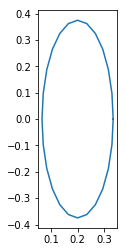

In [4]:
hole = pm.Ellipse(a=hole_a, b=hole_b, x=defect_d/2)
inspect_shapes(hole)

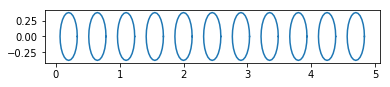

In [5]:
hole_sweep = pm.ParametricSweep(
    constructor=hole.clone,
    sweep_over=np.arange(holes_n),
    sweep_params = {
        'x': lambda n: defect_d/2 + n*lattice_d,
#         'b': lambda n: hole_b if n > 2 else (0.7 + 0.1*n)*hole_b,
#         'a': lambda n: hole_a if n > 2 else (0.7 + 0.1*n)*hole_a,
    }
)

inspect_shapes(hole_sweep)

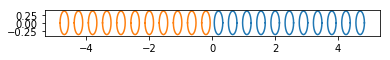

In [6]:
hole_sweep_mirror = pm.Scaled(hole_sweep, scales=(-1.0, 1.0))
inspect_shapes(hole_sweep, hole_sweep_mirror)

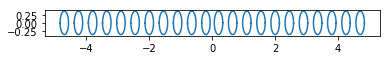

In [7]:
all_holes = pm.Combined([hole_sweep, hole_sweep_mirror])
inspect_shapes(all_holes)

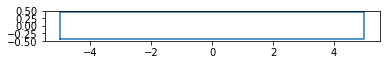

In [8]:
full_beam = pm.Rectangle(x=0.0, y=0.0, w=beam_l, h=beam_w)
inspect_shapes(full_beam)

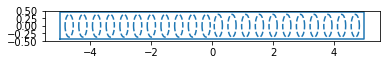

In [9]:
minus_holes = pm.Difference([full_beam, all_holes])
inspect_shapes(minus_holes)

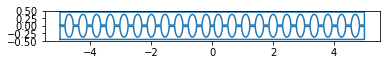

In [10]:
minus_slit = pm.Difference([minus_holes, pm.Rectangle(x=0.0, y=0.0, w=beam_l, h=slit_d)])
inspect_shapes(minus_slit)

In [65]:
final_polys = minus_slit.apply(pm.Expanded).polygonize()

# GDSpy stuff starts here

In [94]:
import gdspy
reload(gdspy)

MAX_VERTICES = 8000

In [95]:
poly_cell = gdspy.Cell('johnbeam')
poly_cell.flatten(single_datatype=1000)

In [96]:
for spoly in final_polys:
    if len(spoly.interiors) > 0:
        print("WARNING: polygon contains interiors, which is not supported by the GDS file format. Ignoring...")
        
    vertices = list(spoly.exterior.coords)
    n_vertices = len(vertices)
    print("Number of vertices: %d" % n_vertices)
    if n_vertices > MAX_VERTICES:
        raise ValueError("Polygon contains more that %d vertices" % MAX_VERTICES)
    gds_poly = gdspy.Polygon(vertices, 1)
    
    poly_cell.add(gds_poly)

poly_cell.flatten(single_datatype=1000)

Number of vertices: 291
Number of vertices: 291


D:\installs\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: [GDSPY] A polygon with more than 199 points was created (not officially supported by the GDSII format).
  # Remove the CWD from sys.path while we load stuff.


In [97]:


gdspy.write_gds("johnbeam.gds", unit=1e-6, precision=1e-9)


In [34]:
type(spoly.exterior.coords)

shapely.coords.CoordinateSequence